In [0]:
%matplotlib inline

# Downgrading torch and vision versions
 The default torch and vision versions showed warning for all the 25,000 images which super spammed the output.


In [2]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 42.9MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


# Imports

In [0]:
import os
import io
import numpy as np
import tarfile
import PIL

from fastai.vision import *

# Downloading dataset from source

In [0]:
os.environ['KAGGLE_USERNAME'] = "ferozkhan05"
os.environ['KAGGLE_KEY'] = "7881a70c1ba66b732f409f8efa63df8a"

In [5]:
! kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

100% 1.76G/1.76G [00:37<00:00, 26.4MB/s]



In [0]:
! unzip -q lung-and-colon-cancer-histopathological-images.zip;


# Moving to a common directory
 Lung and colon images
 from two different directory is moved to common directory.


In [0]:
mkdir Alldataset

In [0]:
mv /content/lung_colon_image_set/colon_image_sets/colon_aca /content/Alldataset #colon_aca

In [0]:
mv /content/lung_colon_image_set/colon_image_sets/colon_n /content/Alldataset   #colon_n

In [0]:
mv /content/lung_colon_image_set/lung_image_sets/lung_aca /content/Alldataset   #lung_aca

In [0]:
mv /content/lung_colon_image_set/lung_image_sets/lung_n /content/Alldataset     #lung_n 

In [0]:
mv /content/lung_colon_image_set/lung_image_sets/lung_scc /content/Alldataset   #lung_scc

# Training the Classifier using fastai

In [0]:
path = Path("/content/Alldataset")

In [0]:
classes = os.listdir('/content/Alldataset')

In [15]:
classes

['lung_n', 'colon_n', 'colon_aca', 'lung_aca', 'lung_scc']

In [16]:
for c in classes:
    verify_images(path/c, delete=True, max_workers=8)

In [0]:
np.random.seed(5)
src = (ImageList.from_folder(path)
      .split_by_rand_pct(valid_pct=0.2)
      .label_from_folder())

In [0]:
tfdm = get_transforms(max_rotate=25, max_zoom=1.3, max_warp=0.4)

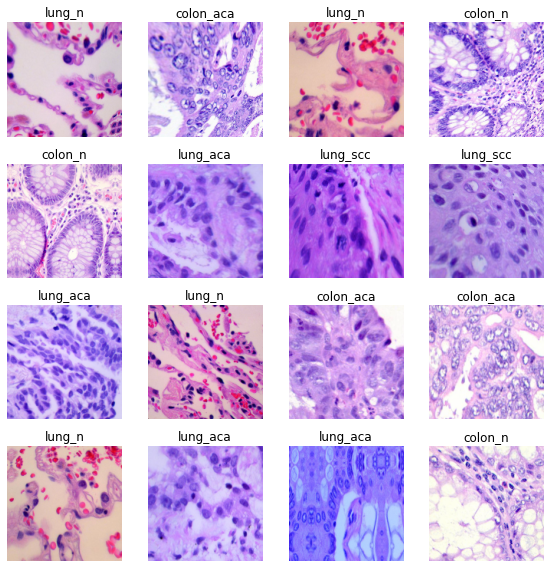

In [19]:
 data =(src.transform(tfdm, size=150)
         .databunch(bs=256)
         .normalize(imagenet_stats))
 
 data.show_batch(rows=4, figsize=(8,8))

In [20]:
learner34 = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


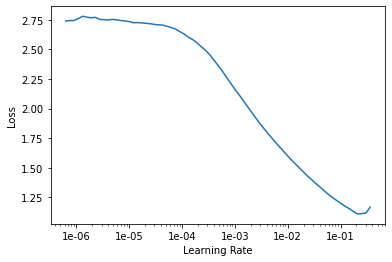

In [21]:
learner34.lr_find()
learner34.recorder.plot()

In [0]:
lr = 1e-03

In [23]:
learner34.fit_one_cycle(10, max_lr=slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.969473,0.185755,0.935000,07:35
1,0.412618,0.102457,0.961200,07:36
2,0.243070,0.074845,0.971600,07:29
3,0.166926,0.068150,0.972600,07:34
4,0.139343,0.054399,0.978400,07:32
5,0.118233,0.047143,0.980800,07:29
6,0.107838,0.042807,0.983400,07:25
7,0.097668,0.040447,0.984400,07:27
8,0.090681,0.039463,0.983600,07:25
9,0.092817,0.040037,0.983800,07:28


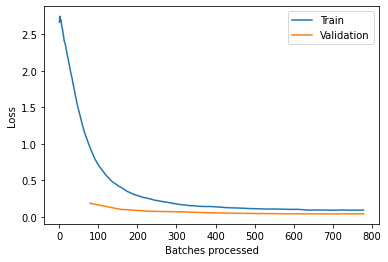

In [24]:
 learner34.recorder.plot_losses()

In [0]:
learner34.save('resnet34-prototype1')

In [26]:
interp = ClassificationInterpretation.from_learner(learner34)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

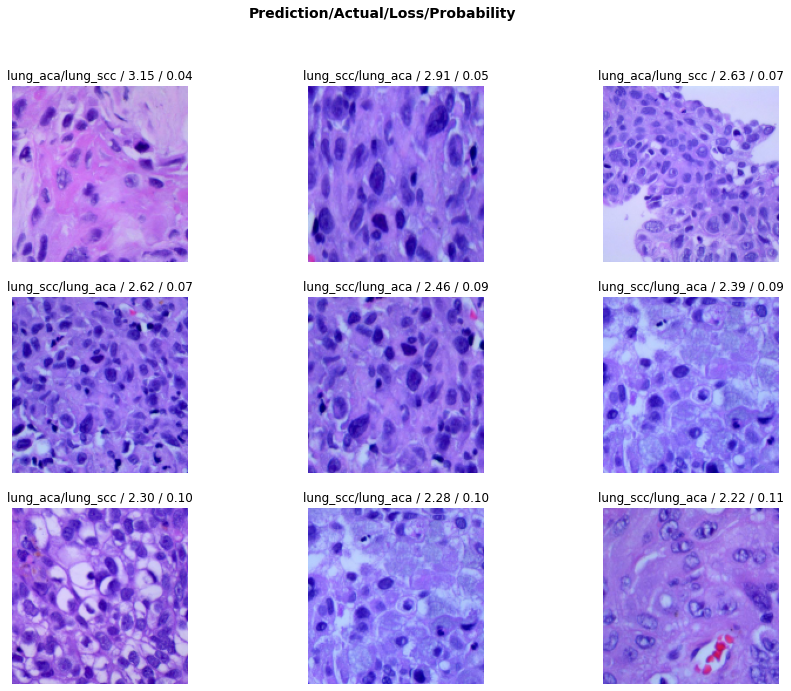

In [27]:
interp.plot_top_losses(9, figsize=(15,11))

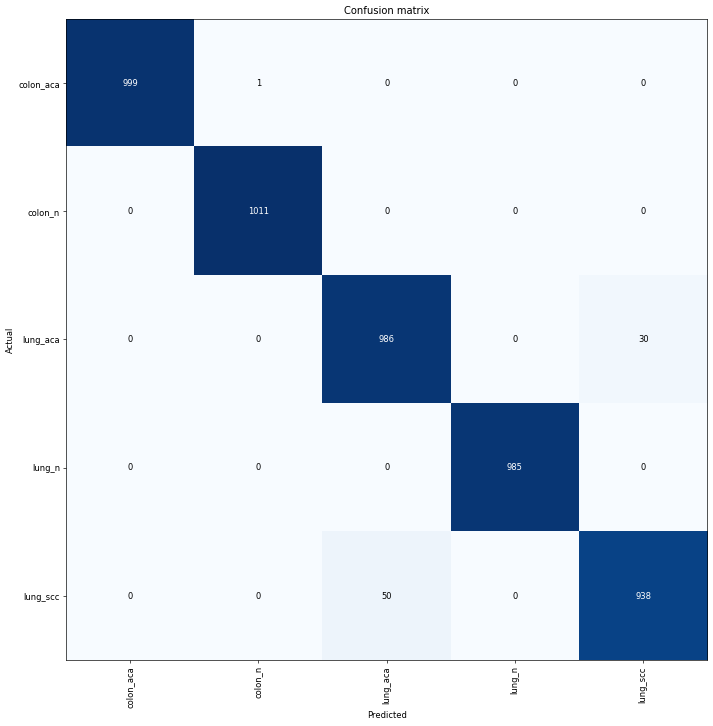

In [28]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [29]:
interp.most_confused(min_val=1)

[('lung_scc', 'lung_aca', 50),
 ('lung_aca', 'lung_scc', 30),
 ('colon_aca', 'colon_n', 1)]

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


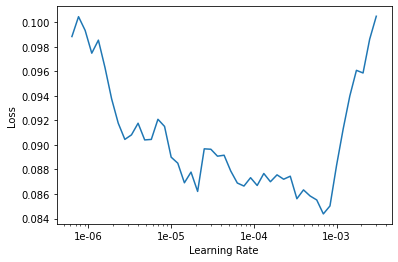

In [30]:
learner34.unfreeze()
learner34.lr_find()
learner34.recorder.plot()

In [31]:
learner34.fit_one_cycle(3, max_lr=slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.072658,0.021809,0.990800,07:24
1,0.051102,0.010719,0.995600,07:25
2,0.037870,0.009442,0.996400,07:24


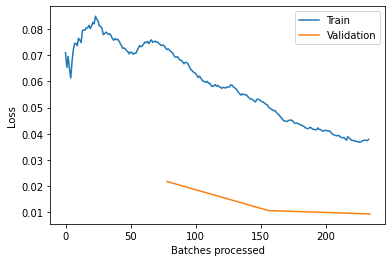

In [32]:
learner34.recorder.plot_losses()

In [33]:
interp = ClassificationInterpretation.from_learner(learner34)

In [34]:
interp.most_confused(min_val=1)

[('lung_scc', 'lung_aca', 12), ('lung_aca', 'lung_scc', 6)]

In [35]:
val_preds,val_targets = learner34.get_preds()

In [36]:
val_preds

tensor([[1.0000e+00, 1.2574e-08, 9.2432e-12, 1.7653e-12, 4.7541e-09],
        [3.1760e-06, 2.3657e-07, 6.6460e-04, 1.7993e-06, 9.9933e-01],
        [6.7175e-05, 1.3636e-06, 9.9865e-01, 1.0887e-03, 1.9102e-04],
        ...,
        [1.8647e-06, 1.0000e+00, 6.2077e-07, 1.9768e-06, 1.0933e-07],
        [5.1412e-05, 2.9560e-08, 5.3239e-07, 5.4769e-10, 9.9995e-01],
        [2.4807e-07, 2.0406e-09, 2.3200e-05, 1.0842e-09, 9.9998e-01]])

In [37]:
val_targets

tensor([0, 4, 2,  ..., 1, 4, 4])

In [0]:
val_preds = val_preds.argmax(dim=1)

In [39]:
val_preds

tensor([0, 4, 2,  ..., 1, 4, 4])

In [40]:
data.classes

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

In [41]:
from sklearn.metrics import classification_report

print(classification_report(val_targets, val_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1011
           2       0.99      0.99      0.99      1016
           3       1.00      1.00      1.00       985
           4       0.99      0.99      0.99       988

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



## Inference Model

Detecting the type of cancer by giving a new image to the trained model. 

In [0]:
learner34.export()

In [0]:
learner34 = load_learner(path)

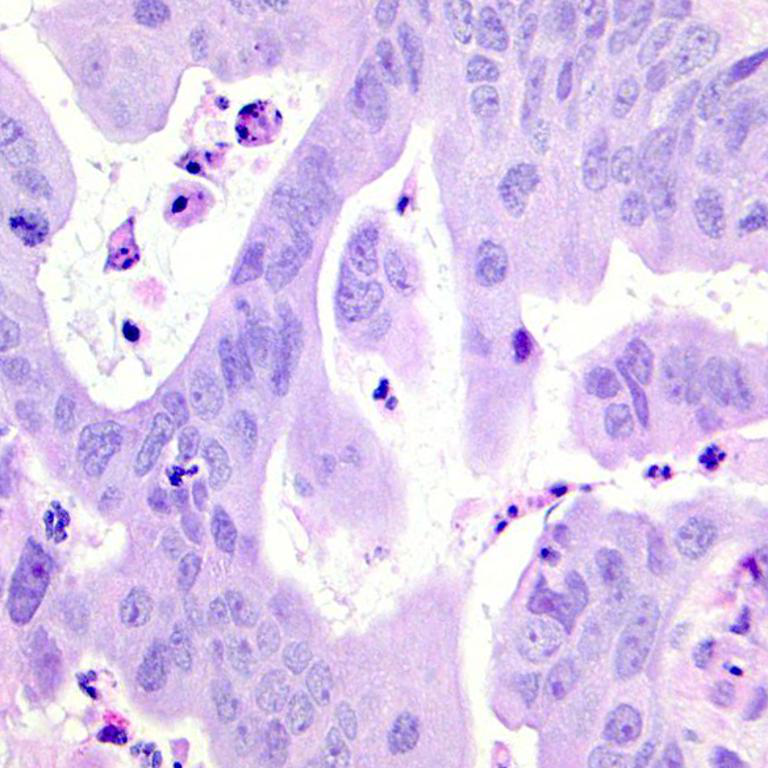

In [69]:
img = open_image("/content/Alldataset/colon_aca/colonca100.jpeg")
img

In [70]:
learner34.predict(img)

(Category tensor(0),
 tensor(0),
 tensor([1.0000e+00, 1.4646e-09, 2.9508e-10, 8.9450e-11, 1.6938e-12]))

In [71]:
pred_class,pred_idx,outputs = learner34.predict(img)
if(pred_class == tensor(0)):
  print("Colon adenocarcinoma")
elif(pred_class == tensor(1)):
  print("Colon benign tissue")
elif(pred_class == tensor(2)):
  print("Lung adenocarcinoma")
elif(pred_class == tensor(3)):
  print("Lung benign tissue")
elif(pred_class == tensor(4)):
  print("Lung squamous cell carcinoma")
  

Colon adenocarcinoma


## Conclusion

Thus, the model successfully predicted the type of cancer and its class from the new image fed.